# SEGMENTACIÓN

In [1]:
# Dependencias tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models
import tensorflow.keras.backend as K

# Dependencia para trabajar con archivos ZIP
import zipfile

# Otras liberías
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from pathlib import Path
import pandas as pd
import seaborn as sns

In [21]:
N_ROWS = 256
N_COLS = 256

def read_image(image_path, mask_path):
    
    # Leemos la imagen del directorio
    image = tf.io.read_file(image_path)
    # Decodificamos la imagen en función del tipo de codificación (PNG) en nuestro caso
    image = tf.image.decode_png(image, channels=1)
    # Convertimos la imagen a float32 --> Este método al mismo tiempo, al especificarle tipo de dato float hace el escalado a [0,1]
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Redimensionamos la imagen al tamaño deseado
    image = tf.image.resize(image, (N_ROWS, N_COLS), method='nearest')

    # Leemos la máscara del directorio
    mask = tf.io.read_file(mask_path)
    # Decodificamos la imagen en función del tipo de codificación (PNG) en nuestro caso
    mask = tf.image.decode_png(mask, channels=1)
    print('shape:', mask.shape)

    # Las máscaras están guardadas de manera que el número de la etiqueta (0-12) se encuentra en el primer canal
    # Por lo tanto, nos quedamos con el valor máximo de cada canal para crear una matriz de tamaño [FILAS, COLUMNAS, 1]
    print('max value of channel:', tf.reduce_max(mask))
    mask /= 255
    mask = tf.cast(mask, tf.uint8)
    
    # Redimensionamos la imagen al tamaño deseado
    mask = tf.image.resize(mask, (N_ROWS, N_COLS), method='nearest')
    
    return image, mask

In [22]:
def dataset_generator(image_paths, mask_paths, buffer_size, batch_size):
    
    image_list = tf.constant(image_paths) 
    mask_list = tf.constant(mask_paths)
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    # A cada elemento del dataset (directorios imagenes y máscaras) les aplicamos el método read_image
    dataset = dataset.map(read_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache().shuffle(buffer_size).batch(batch_size)
    
    return dataset

In [23]:
img_dir_train = 'data/model2_data/train/images/'
mask_dir_train = 'data/model2_data/train/masks/'
train_image_paths = glob.glob(os.path.join(img_dir_train, '*.png'))
train_mask_paths = glob.glob(os.path.join(mask_dir_train, '*.png'))

img_dir_val = 'data/model2_data/validation/images/'
mask_dir_val = 'data/model2_data/validation/masks/'
val_image_paths = glob.glob(os.path.join(img_dir_val, '*.png'))
val_mask_paths = glob.glob(os.path.join(mask_dir_val, '*.png'))

img_dir_test = 'data/model2_data/test/images/'
mask_dir_test = 'data/model2_data/test/masks/'
test_image_paths = glob.glob(os.path.join(img_dir_test, '*.png'))
test_mask_paths = glob.glob(os.path.join(mask_dir_test, '*.png'))

print('Número de imágenes de entrenamiento: ', len(train_image_paths))
print('Número de imágenes de validación: ', len(val_image_paths))
print('Número de imágenes de test: ', len(test_image_paths))

print('\nNúmero de máscaras de entrenamiento: ', len(train_mask_paths))
print('Número de máscaras de validación: ', len(val_mask_paths))
print('Número de máscaras de test: ', len(test_mask_paths))

Número de imágenes de entrenamiento:  2000
Número de imágenes de validación:  319
Número de imágenes de test:  319

Número de máscaras de entrenamiento:  2000
Número de máscaras de validación:  319
Número de máscaras de test:  319


In [5]:
# image,mask = read_image('/run/media/alumno/ISMA/IABD/PIA/PRACTICA FINAL ANA/data/model2_data/validation/images/0001_0.png', '/run/media/alumno/ISMA/IABD/PIA/PRACTICA FINAL ANA/data/model2_data/validation/masks/0001_0.png')

In [24]:
BATCH_SIZE = 32
BUFFER_SIZE = 500

train_dataset = dataset_generator(train_image_paths, train_mask_paths, BUFFER_SIZE, BATCH_SIZE)
validation_dataset = dataset_generator(val_image_paths, val_mask_paths, BUFFER_SIZE, BATCH_SIZE)
test_dataset = dataset_generator(test_image_paths, test_mask_paths, BUFFER_SIZE, BATCH_SIZE)

shape: (None, None, 1)
max value of channel: Tensor("Max:0", shape=(), dtype=uint8)
shape: (None, None, 1)
max value of channel: Tensor("Max:0", shape=(), dtype=uint8)
shape: (None, None, 1)
max value of channel: Tensor("Max:0", shape=(), dtype=uint8)


(256, 256, 1)


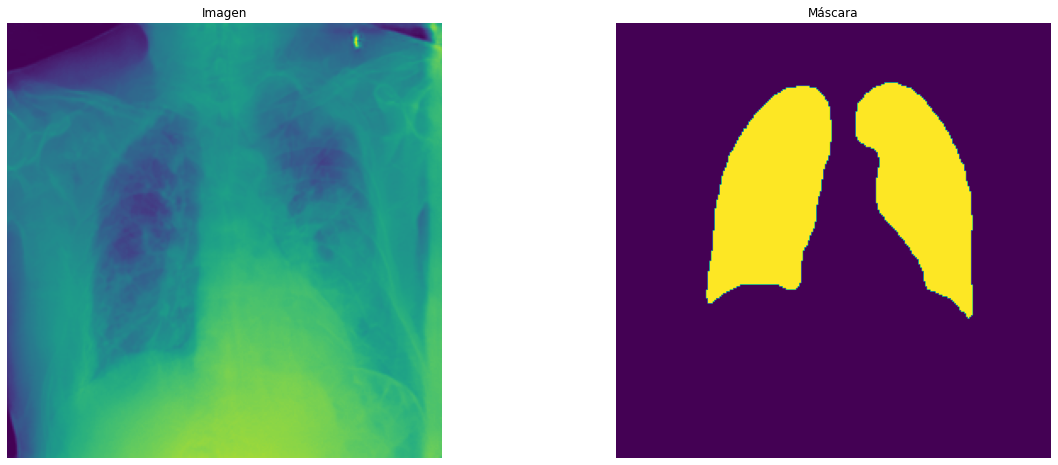

(256, 256, 1)


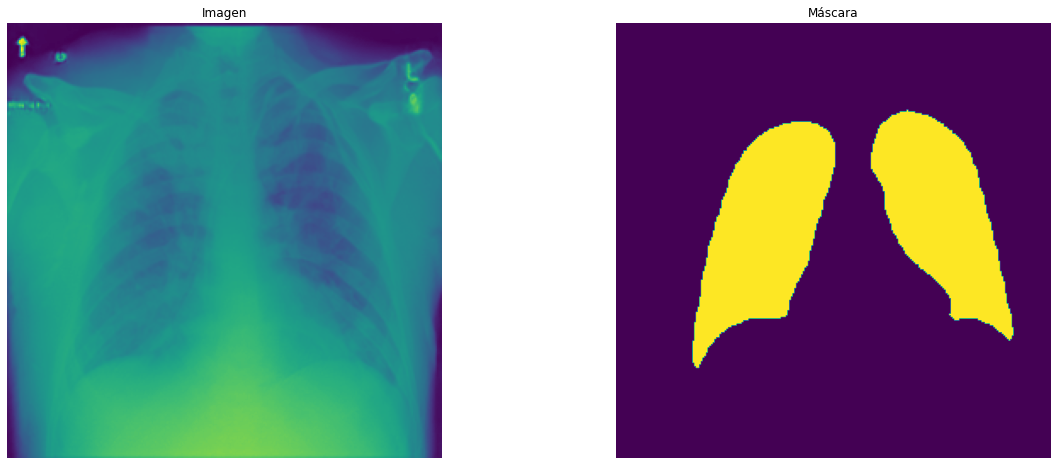

(256, 256, 1)


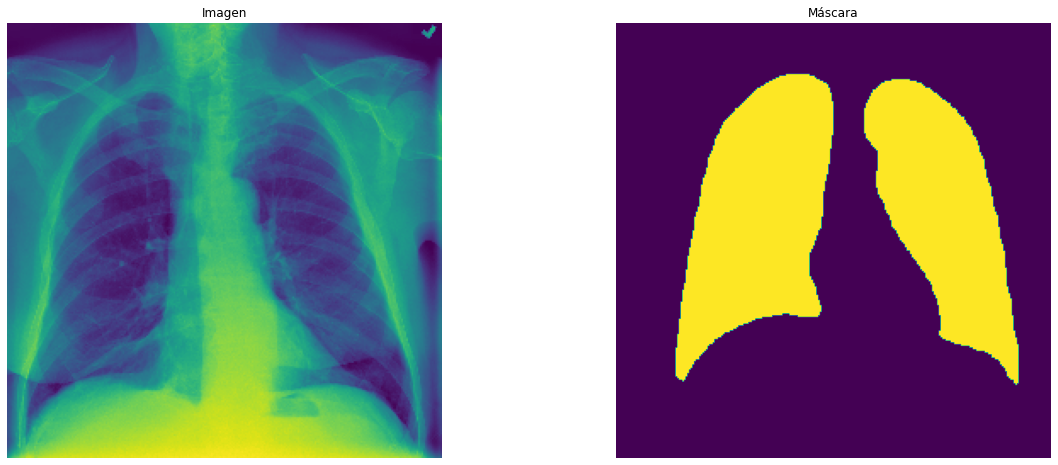

In [25]:
for images, masks in train_dataset.take(1):
  for i in range(3):
    image, mask = images[i], masks[i]

    print(mask.shape)

    plt.figure(figsize=(20,8))
    plt.subplot(121)
    plt.imshow(image)
    plt.axis('off')
    plt.title('Imagen')
    plt.subplot(122)
    plt.imshow(mask)
    plt.axis('off')
    plt.title('Máscara')
    plt.show()

In [8]:
IMAGE_SHAPE = (N_ROWS, N_COLS, 3)
ACTIVATION = 'sigmoid'
N_LABELS = 1

def get_unet():
    # Encoding phase
    inputs = layers.Input(IMAGE_SHAPE)
    conv1 = layers.Conv2D(32, (3, 3), padding='same')(inputs)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Activation('relu')(conv1)
    conv1 = layers.Conv2D(32, (3, 3), padding='same')(conv1)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Activation('relu')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(64, (3, 3), padding='same')(pool1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Activation('relu')(conv2)
    conv2 = layers.Conv2D(64, (3, 3), padding='same')(conv2)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Activation('relu')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(128, (3, 3), padding='same')(pool2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Activation('relu')(conv3)
    conv3 = layers.Conv2D(128, (3, 3), padding='same')(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Activation('relu')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(256, (3, 3), padding='same')(pool3)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Activation('relu')(conv4)
    conv4 = layers.Conv2D(256, (3, 3), padding='same')(conv4)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Activation('relu')(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    # Decoding phase
    conv5 = layers.Conv2D(512, (3, 3), padding='same')(pool4)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.Activation('relu')(conv5)
    conv5 = layers.Conv2D(512, (3, 3), padding='same')(conv5)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.Activation('relu')(conv5)

    up6 = layers.concatenate([layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = layers.Conv2D(256, (3, 3), padding='same')(up6)
    conv6 = layers.BatchNormalization()(conv6)
    conv6 = layers.Activation('relu')(conv6)
    conv6 = layers.Conv2D(256, (3, 3), padding='same')(conv6)
    conv6 = layers.BatchNormalization()(conv6)
    conv6 = layers.Activation('relu')(conv6)

    up7 = layers.concatenate([layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = layers.Conv2D(128, (3, 3), padding='same')(up7)
    conv7 = layers.BatchNormalization()(conv7)
    conv7 = layers.Activation('relu')(conv7)
    conv7 = layers.Conv2D(128, (3, 3), padding='same')(conv7)
    conv7 = layers.BatchNormalization()(conv7)
    conv7 = layers.Activation('relu')(conv7)

    up8 = layers.concatenate([layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = layers.Conv2D(64, (3, 3), padding='same')(up8)
    conv8 = layers.BatchNormalization()(conv8)
    conv8 = layers.Activation('relu')(conv8)
    conv8 = layers.Conv2D(64, (3, 3), padding='same')(conv8)
    conv8 = layers.BatchNormalization()(conv8)
    conv8 = layers.Activation('relu')(conv8)

    up9 = layers.concatenate([layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = layers.Conv2D(32, (3, 3), padding='same')(up9)
    conv9 = layers.BatchNormalization()(conv9)
    conv9 = layers.Activation('relu')(conv9)
    conv9 = layers.Conv2D(32, (3, 3), padding='same')(conv9)
    conv9 = layers.BatchNormalization()(conv9)
    conv9 = layers.Activation('relu')(conv9)

    out = layers.Conv2D(N_LABELS, (1, 1))(conv9)

    # Output
    output = layers.Activation(ACTIVATION)(out)

    # Compile model with inputs and outputs
    model = models.Model(inputs=[inputs], outputs=[output])

    return model


In [9]:
model_unet = get_unet()

model_unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [10]:
path_models = Path('data/model2_data/models/exp')
path_models.mkdir(exist_ok=True, parents = True)

In [11]:
smooth = 1

def iou(targets, inputs):
    
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    intersection = K.sum(targets * inputs)
    total = K.sum(targets) + K.sum(inputs)
    union = total - intersection
    
    IoU = (intersection + smooth) / (union + smooth)
    return IoU

In [12]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


NOTA: En el ordenador de casa, no me deja hacer uso de la gpu para el entrenamiento y tarda demasiado con la cpu, asi que he hecho uso del modelo y del history.npy de Héctor Navarro. Había pensado en hacer más pequeño el dataset pero para que los resultados sean más realistas, he decidido en hacer lo anterior

In [ ]:
EPOCHS = 50

model_unet.compile(optimizer='adam', 
                   loss='binary_crossentropy',
                   metrics=['accuracy', iou])

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=path_models / 'model.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

with tf.device("gpu:0"):
    history_unet = model_unet.fit(train_dataset,
                                epochs=EPOCHS,
                                steps_per_epoch= int(2000/BATCH_SIZE),
                                validation_steps = int(319/BATCH_SIZE),
                                validation_data=validation_dataset,
                                callbacks=[model_checkpoint_callback],
                                verbose=1)

np.save(path_models / 'history.npy', history_unet.history)

In [18]:
history_model = np.load(Path('data/model2_data/models/exp/history_model2.npy'), allow_pickle=True)
history_model = history_model.tolist()

model_unet = tf.keras.models.load_model('data/model2_data/models/exp/segmentation_model.h5', custom_objects={'iou':iou})

In [31]:
# Observamos visualmente la predicciones comparadas con las segmentaciones de referencia en algunas imágenes del set de test
def show_prediction(model):
  for images, masks in test_dataset.take(1):
    
    pred_masks = model_unet.predict(images)
    for i in range(3):

      image, mask = images[i], masks[i]
      pred_mask = pred_masks[i]

      print(pred_mask.shape)

      plt.figure(figsize=(20,10))
      plt.subplot(131)
      plt.imshow(image)
      plt.axis('off')
      plt.title('Imagen')
      plt.subplot(132)
      plt.imshow(mask)
      plt.axis('off')
      plt.title('Máscara real')
      plt.subplot(133)
      plt.imshow(pred_mask)
      plt.axis('off')
      plt.title('Máscara predicha')
      plt.show()

1/1 [==============================] - 6s 6s/step
(256, 256, 1)


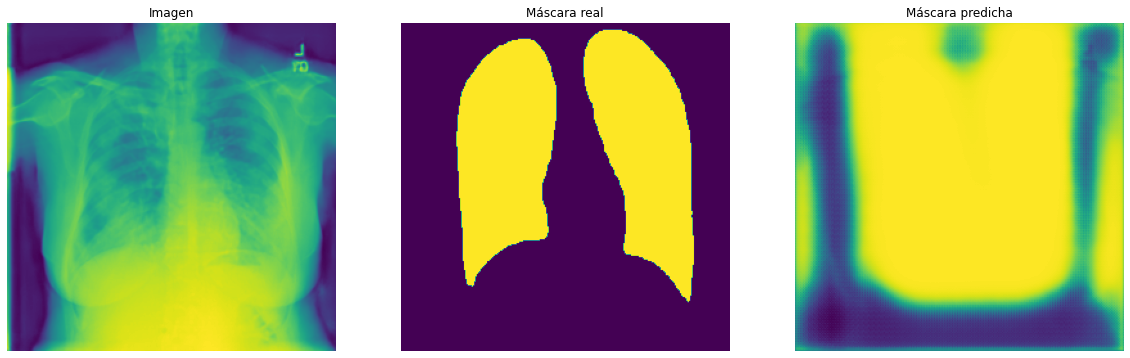

(256, 256, 1)


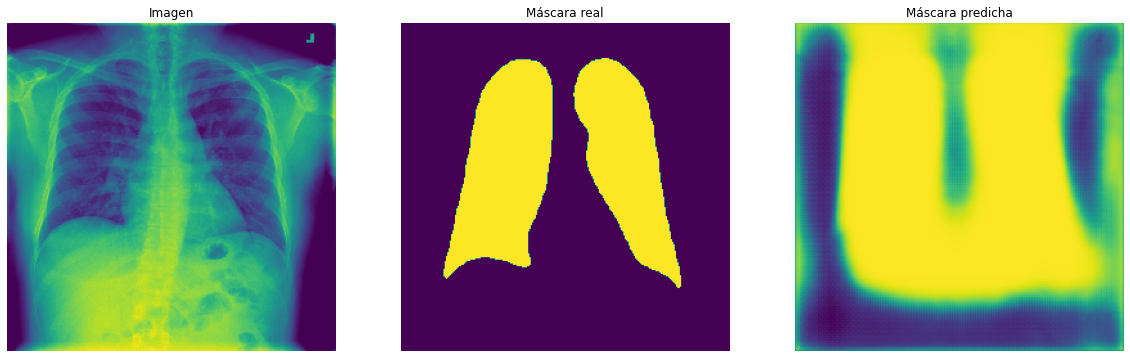

(256, 256, 1)


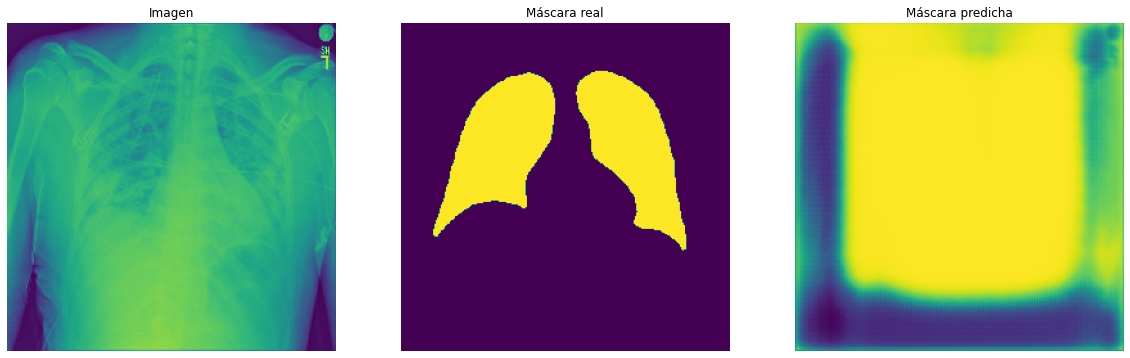

In [32]:
show_prediction(model_unet)

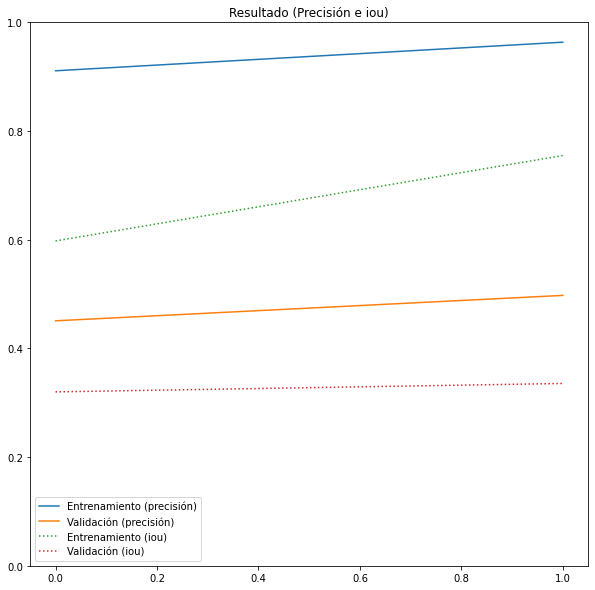

In [47]:
plt.figure(figsize=(10, 10))
plt.plot(history_model['accuracy'], label='Entrenamiento (precisión)')
plt.plot(history_model['val_accuracy'], label='Validación (precisión)')
plt.plot(history_model['iou'], label='Entrenamiento (iou)', linestyle=':')
plt.plot(history_model['val_iou'], label='Validación (iou)', linestyle=':')
plt.title('Resultado (Precisión e iou)')
plt.ylim([0,1])
plt.legend()